In [1]:
from qiskit import *
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.stats import rv_continuous
from qiskit.circuit import Parameter, ParameterVector

In [2]:
def unitary(circ,eta,phi,t):
    theta = np.arccos(-eta);
    circ.u3(theta,phi,t,0);

In [3]:
class PQC:
    def __init__(self,name,layer):
        self.backend = Aer.get_backend('statevector_simulator');
        self.circ = QuantumCircuit(layer);
        self.name = name;
        self.seed = 14256;
        self.layer = layer;
        np.random.seed(self.seed);
        if self.name == "rcz":
            self.theta = Parameter('θ');
            for index in range(layer):
                self.circ.h(index);
            c = QuantumCircuit(1,name="Rz");
            c.rz(self.theta,0);
            temp = c.to_gate().control(1);
            self.circ.append(temp,[0,1]);
        if self.name == "circ4":
            self.theta1 = ParameterVector('θ1', layer);
            self.theta2 = ParameterVector('θ2', layer);
            self.theta3 = ParameterVector('θ3', layer-1);
            # print(self.theta1)
            for i in range(self.layer):
                self.circ.rx(self.theta1[i],i);
            for i in range(self.layer):
                self.circ.rz(self.theta2[i],i);
            for i in range(self.layer-1):
                c = QuantumCircuit(1, name="Rx");
                c.rz(self.theta3[i],0);
                temp = c.to_gate().control(1);
                self.circ.append(temp,[i,i+1]);

    def get(self):
        if self.name == "rcz":
            t = np.random.uniform(0,2*np.pi);
            # theta = Parameter('θ');
            self.circ1 = self.circ.assign_parameters({self.theta:t});
            result = execute(self.circ1,self.backend).result();
            out_state = result.get_statevector();
            self.statevector = np.asmatrix(out_state).T;
            return self.statevector;
        if self.name == "circ4":
            self.circ1 = self.circ.bind_parameters({self.theta1: np.random.uniform(0,2*np.pi,self.layer)});
            self.circ2 = self.circ1.bind_parameters({self.theta2: np.random.uniform(0,2*np.pi,self.layer)});
            self.circ3 = self.circ2.bind_parameters({self.theta3: np.random.uniform(0,2*np.pi,self.layer-1)});
            result = execute(self.circ3,self.backend).result();
            out_state = result.get_statevector();
            self.statevector = np.asmatrix(out_state).T;
            return self.statevector;

    def draw(self):
        self.circ.draw('mpl');
        print(self.circ);

In [4]:
pqc = PQC("circ4",2);

In [5]:
pqc.draw()

     ┌───────────┐┌───────────┐             
q_0: ┤ RX(θ1[0]) ├┤ RZ(θ2[0]) ├──────■──────
     ├───────────┤├───────────┤┌─────┴─────┐
q_1: ┤ RX(θ1[1]) ├┤ RZ(θ2[1]) ├┤ Rx(θ3[0]) ├
     └───────────┘└───────────┘└───────────┘


In [6]:
def Haar(F,N):
    if F<0 or F>1:
        return 0;
    return (N-1)*(1-F)**(N-2);
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0));
class Haar_dist(rv_continuous):
    def _pdf(self,x):
        return Haar(x,1*2);

In [7]:
def expressibility(pqc, reps):
    arr = [];
    for i in range(reps):
        fid = np.abs(pqc.get().getH()*pqc.get())**2;
        arr.append(fid[0,0]);
        if i%100==0 and i!=0:
            print(i,"\n");
    haar = [];
    h = Haar_dist(a=0,b=1,name="haar");
    for i in range(reps):
        haar.append(h.ppf((i+0.5)/reps));
    n_bins = 100;
    haar_pdf = plt.hist(np.array(haar), bins=n_bins, alpha=0.5)[0]/reps; 
    pqc_pdf = plt.hist(np.array(arr), bins=n_bins, alpha=0.5)[0]/reps;
    kl = kl_divergence(pqc_pdf,haar_pdf);
    plt.title('KL(P||Q) = %1.4f' % kl)
    return kl;

100 

200 

300 

400 

500 

600 

700 

800 

900 

0.4254938329547451


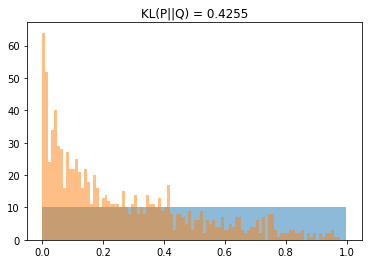

In [8]:
print(expressibility(pqc, 1000))